# Google trends data exploration

In [9]:
import pandas as pd
import numpy as np
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
from graphviz import Digraph
from collections import deque

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
pytrends = TrendReq(hl='en-US', tz=360)

### Setup a payload for 'Bitcoin' in the US 

In [11]:
kw = "Bitcoin"
kw_list = [kw]
pytrends.build_payload(kw_list, cat=0, timeframe='all', geo='US', gprop='')

In [22]:
# Get the keyword interest dataframe.
interest_df = pytrends.interest_over_time()
interest_df.tail()

,price of bitcoin,isPartial
date,,
2019-01-01,8,False
2019-02-01,7,False
2019-03-01,6,False
2019-04-01,9,False
2019-05-01,15,True


#### What do the numbers represent?
From google trends: "Numbers represent search interest relative to the highest point on the chart for the given region and time. A value of 100 is the peak popularity for the term. A value of 50 means that the term is half as popular. A score of 0 means there was not enough data for this term."

### Check for null entries

In [13]:
has_null = any(interest_df[kw].isnull())
if has_null:
    print("Null entries found... removing null entries")
    interest_df = interest_df.dropna()
    has_null = any(interest_df['Gas prices'].isnull())
    
assert not has_null

### Check that there is consistent time granularity between rows

In [14]:
for i in range(interest_df.shape[0] - 1):
    entry_time_difference = interest_df.index[i + 1] - interest_df.index[i]
    x = list(entry_time_difference.components)
    assert sum(x) == max(x)

# A sample difference in time between rows.
print("Time granularity is approximately:", entry_time_difference)

Time granularity is approximately: 30 days 00:00:00


### Describe data

In [15]:
interest_df.describe()

,Bitcoin
count,185.000000
mean,3.562162
std,9.564295
min,0.000000
25%,0.000000
50%,0.000000
75%,3.000000
max,100.000000


### Visualize the data

Text(0, 0.5, 'Interest in Bitcoin')

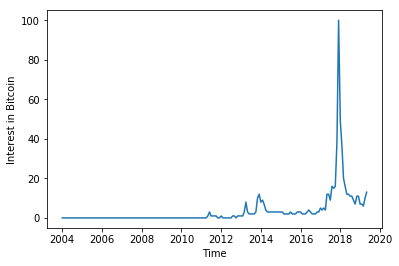

In [17]:
plt.plot(interest_df[kw])
plt.xlabel('Time')
plt.ylabel('Interest in {}'.format(kw))

We see that the peak search for bitcoin occurred in 2018 when bitcoin became extremely popular.

## Using related queries as feedback to get more results

The google trends API has the ability to provide suggested search terms given a query. Here, we use this feature to grow a graph of related search terms based on google recommendations.

The parameters for this search are the number of iterations to run the search for, and $k$, the number of related queries to include for each search term.

In [18]:
# A function to return related keywords to a given keyword.
def get_related_for_keyword(kw):
    kw_list = [kw]
    pytrends.build_payload(kw_list, cat=0, timeframe='all', geo='US', gprop='')
    interest_df = pytrends.interest_over_time()
    return pytrends.related_queries()

In [35]:
# Modify these to grow the size of the tree and to choose a different starting keyword
start_kw = 'Bitcoin'
num_iters = 5
k = 3 # Top-k related keywords to find per word

graph_dict = {}
q = deque()
q.append(start_kw)

for i in range(num_iters):
    # get the next keyword
    kw = q.popleft()
    print("Finding related terms to {}...".format(kw))
    
    # Get related keywords for given keyword
    related = get_related_for_keyword(kw)

    # Get the top k related keywords
    top_k = list(related[kw]['top'][:k]['query'].values)
    
    # Add to graph data dict
    if kw not in graph_dict:
        graph_dict[kw] = []
    graph_dict[kw] = top_k
    
    q.extend(top_k)
print("Done")

Finding related terms to Bitcoin...
Finding related terms to bitcoin price...
Finding related terms to bitcoin usd...
Finding related terms to buy bitcoin...
Finding related terms to price of bitcoin...
Done


### Generate a graph from the search results

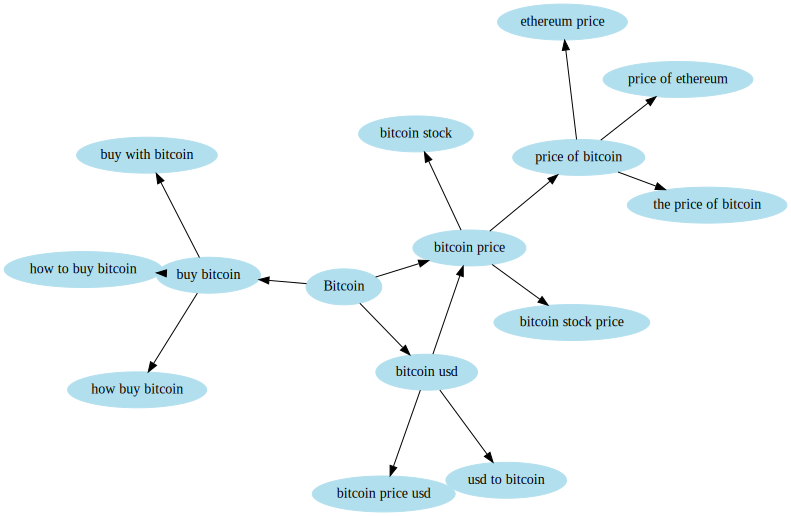

In [36]:
dot = Digraph(engine='neato')
dot.node_attr.update(color='lightblue2', style='filled')
dot.edge_attr.update(len='1.6')

for kw in graph_dict:
    dot.node(kw, kw)
    for child in graph_dict[kw]:
        dot.node(child, child)
        dot.edge(kw, child, length='1')
dot

### Optionally render/export the graph

In [32]:
dot.render(start_kw, view=True, cleanup=True, format='png')

'Donald Trump.png'